#Semantic Segmentation
Semantic Segmentation, which is a pixel level image classification, is an important technique for scene understanding. Because each pixel is labeled as belonging to the given semantic class.

Autonomous driving will be one of the revolutionary technologies in the near future in terms of the impact of lives of the people living in industrially developed countries. An autonomous vehicle must sense it's surroundings and act safely to reach a certain target. Such functionality is carried out by using several types of classifiers.

In a typical task of scene underastanding, the classes could be road, street,traffic signs, street markings, cars, pedestrians, side walks, trees.

In this notebook, we are implementing U-Net model which can detect, capture the semantic information and differentiate between different objects around in the scene.

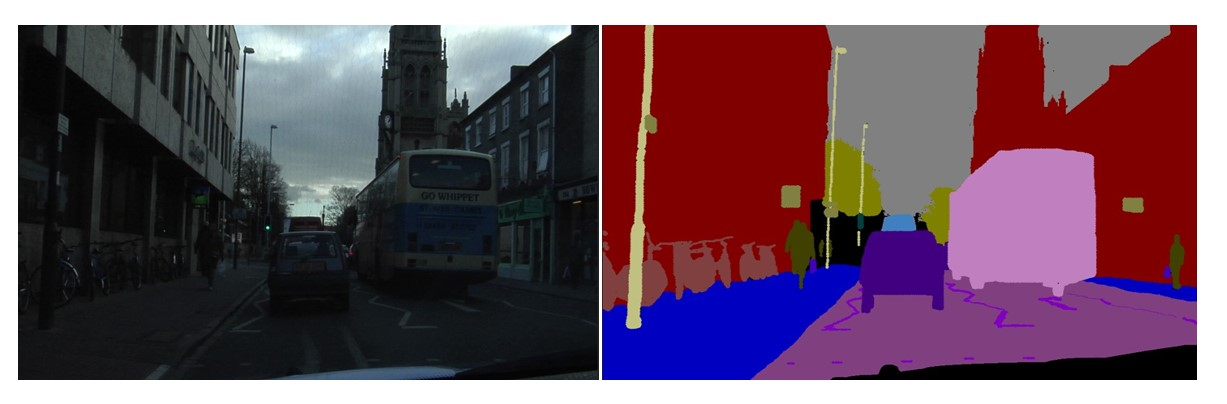

##**Mounting** **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Importing** **Necessary** **Libraries**

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

##**Paths** **to** **Data**

In [ ]:
train_path = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/train'
train_mask = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/train_labels'
test_path = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/test'
test_mask = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/test_labels'
val_path = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/val'
val_mask = '/content/drive/MyDrive/Semantic Segmentation ml 203/Dataset_60/val_labels'

##**Function to Load Data**


*   Resizing images
*   Converting images into arrays
*   Loading all images into list




In [ ]:
## defining a frame for image and mask storage
Train = {'img' : [],
           'mask' : []
          }

Val = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( Data = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = os.listdir(maskPath)

    #make sure images are not jumbled
    imgNames.sort()
    maskNames.sort()
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        Data['img'].append(np.array(img))
        Data['mask'].append(np.array(mask))
        
    return Data

In [ ]:
Train = LoadData( Train, imgPath = train_path, maskPath = train_mask
         , shape = 256)

In [ ]:
Val = LoadData( Val, imgPath = val_path, maskPath = val_mask
         , shape = 256)

##**Sample to the Data**

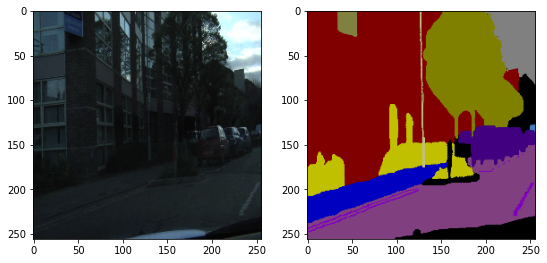

In [ ]:
plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.imshow(Train['img'][15])
plt.subplot(1,2,2)
plt.imshow(Train['mask'][15])
plt.show()

##**Unet** **Model**
**U-Net** is an architecture for semantic segmentation. U-Net consists of Convolution Operation, Max Pooling, ReLU Activation, Concatenation and Up Sampling Layers and three sections: contraction, bottleneck, and expansion section. the contractions section has 4 contraction blocks. Every contraction block gets an input, applies two 3X3 convolution ReLu layers and then a 2X2 max pooling. The number of feature maps gets double at each pooling layer. The bottleneck layer uses two 3X3 Conv layers and 2X2 up convolution layer. The expansion section consists of several expansion blocks with each block passing the input to two 3X3 Conv layers and a 2X2 upsampling layer that halves the number of feature channels. It also includes a concatenation with the correspondingly cropped feature map from the contracting path. In the end, 1X1 Conv layer is used to make the number of feature maps as same as the number of segments which are desired in the output. U-net uses a loss function for each pixel of the image. This helps in easy identification of individual cells within the segmentation map. Softmax is applied to each pixel followed by a loss function. This converts the segmentation problem into a classification problem where we need to classify each pixel to one of the classes.

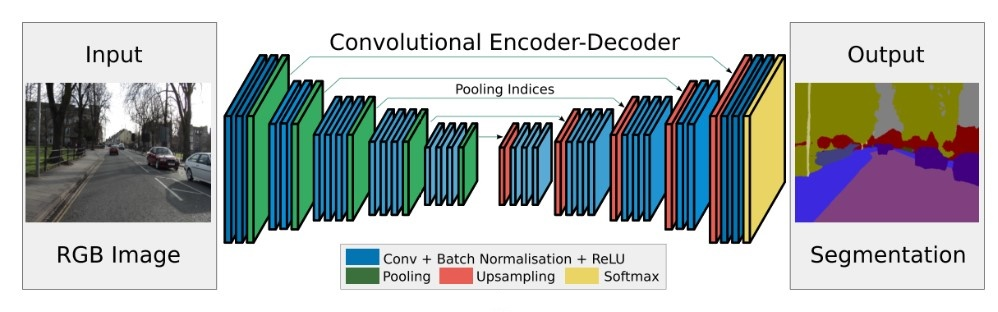

In [ ]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model
inputs = tf.keras.layers.Input((256, 256, 3))

# **Model** **fitting**



*   Instancing the model and compiling it.
*   Fitting model with Training data using 150*12 epochs



##**metric - accuracy**



*  Accuracy is the percent of pixels in your image that are classified correctly



In [ ]:
## instanctiating model
model1 = GiveMeUnet(inputs, droupouts= 0.07)
model1.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
## trainign our model
history1 = model1.fit(np.array(Train['img']), np.array(Train['mask']), validation_data = (np.array(Val['img']), np.array(Val['mask'])), epochs = 150, steps_per_epoch=20, verbose = 1)

Epoch 1/150
20/20 [==============================] - 56s 3s/step - loss: 0.6953 - accuracy: 0.2931 - val_loss: 60.6980 - val_accuracy: 0.0266
Epoch 2/150
20/20 [==============================] - 53s 3s/step - loss: 0.6450 - accuracy: 0.3844 - val_loss: 18.1626 - val_accuracy: 0.1182
Epoch 3/150
20/20 [==============================] - 53s 3s/step - loss: 0.6191 - accuracy: 0.4036 - val_loss: 4.6998 - val_accuracy: 0.2967
Epoch 4/150
20/20 [==============================] - 53s 3s/step - loss: 0.6152 - accuracy: 0.4107 - val_loss: 1.1494 - val_accuracy: 0.4803
Epoch 5/150
20/20 [==============================] - 53s 3s/step - loss: 0.6089 - accuracy: 0.4667 - val_loss: 0.6767 - val_accuracy: 0.5406
Epoch 6/150
20/20 [==============================] - 53s 3s/step - loss: 0.6117 - accuracy: 0.5383 - val_loss: 0.6765 - val_accuracy: 0.5122
Epoch 7/150
20/20 [==============================] - 53s 3s/step - loss: 0.6146 - accuracy: 0.5147 - val_loss: 0.6602 - val_accuracy: 0.5346
Epoch 8/150

##**metric - iou_score**

**Installing necessary Libraries**

In [ ]:
!pip install tensorflow==2.1.0
!pip install segmentation-models




*   IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth



In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [ ]:
## instanctiating model
model2 = GiveMeUnet(inputs, droupouts= 0.07)
model2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [iou_score] )
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
## trainign our model
history2 = model2.fit(np.array(Train['img']), np.array(Train['mask']), validation_data = (np.array(Val['img']), np.array(Val['mask'])), epochs = 150, steps_per_epoch=20, verbose = 1)

Train on 60 samples, validate on 60 samples
Epoch 1/150
60/60 [==============================] - 64s 1s/sample - loss: 0.6743 - iou_score: 0.2727 - val_loss: 1.5232 - val_iou_score: 0.2369
Epoch 2/150
60/60 [==============================] - 61s 1s/sample - loss: 0.6376 - iou_score: 0.2639 - val_loss: 3.9536 - val_iou_score: 0.2254
Epoch 3/150
60/60 [==============================] - 60s 1s/sample - loss: 0.6251 - iou_score: 0.2650 - val_loss: 0.6846 - val_iou_score: 0.2636
Epoch 4/150
60/60 [==============================] - 60s 1s/sample - loss: 0.6154 - iou_score: 0.2666 - val_loss: 3.2468 - val_iou_score: 0.1807
Epoch 5/150
60/60 [==============================] - 60s 1s/sample - loss: 0.6149 - iou_score: 0.2651 - val_loss: 0.6596 - val_iou_score: 0.2576
Epoch 6/150
60/60 [==============================] - 60s 1s/sample - loss: 0.6091 - iou_score: 0.2688 - val_loss: 0.6765 - val_iou_score: 0.2680
Epoch 7/150
60/60 [==============================] - 60s 1s/sample - loss: 0.6058 - io

##**metric - dice coefficient**

**Installing necessary Libraries**

In [ ]:
!pip install tensorflow==2.4.1



*   Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images



In [ ]:
from keras.losses import binary_crossentropy
def dice_coefficient(test_y, pred_y):
    numerator = 2 * tf.reduce_sum(test_y * pred_y)
    denominator = tf.reduce_sum(test_y + pred_y)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
## instanctiating model
model3 = GiveMeUnet(inputs, droupouts= 0.07)
model3.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [dice_coefficient] )
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
## trainign our model
history3 = model3.fit(np.array(Train['img']), np.array(Train['mask']), validation_data = (np.array(Val['img']), np.array(Val['mask'])), epochs = 150, steps_per_epoch=20, verbose = 1)

Epoch 1/150
20/20 [==============================] - 66s 3s/step - loss: 1.5213 - dice_coefficient: 0.4740 - val_loss: 5.0852 - val_dice_coefficient: 0.4493
Epoch 2/150
20/20 [==============================] - 65s 3s/step - loss: 1.4229 - dice_coefficient: 0.4924 - val_loss: 10.9537 - val_dice_coefficient: 0.4609
Epoch 3/150
20/20 [==============================] - 66s 3s/step - loss: 1.3850 - dice_coefficient: 0.5031 - val_loss: 4.6025 - val_dice_coefficient: 0.4799
Epoch 4/150
20/20 [==============================] - 66s 3s/step - loss: 1.3738 - dice_coefficient: 0.5005 - val_loss: 1.8135 - val_dice_coefficient: 0.4868
Epoch 5/150
20/20 [==============================] - 73s 4s/step - loss: 1.3660 - dice_coefficient: 0.5037 - val_loss: 1.5319 - val_dice_coefficient: 0.4718
Epoch 6/150
20/20 [==============================] - 66s 3s/step - loss: 1.3587 - dice_coefficient: 0.5064 - val_loss: 1.6612 - val_dice_coefficient: 0.4841
Epoch 7/150
20/20 [==============================] - 66s 

#**To plot**

In [ ]:
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask') 

# **Predicting** **values**

*   Predicting the masks for validation data 
*   Plotting image, it's predicted mask and the original mask
*   Observing how good the model is predicting
*   Checking the accuracy

##**metric - accuracy**

In [ ]:
pred_val = model1.predict(np.array(Val['img']), verbose=1)

2/2 [==============================] - 9s 4s/step


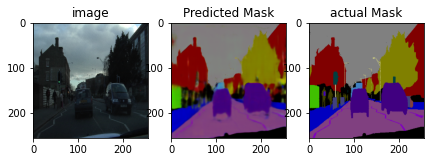

In [ ]:
Plotter(Val['img'][4], pred_val[4], Val['mask'][4])

In [ ]:
_, acc = model1.evaluate(np.array(Val['img']), np.array(Val['mask']), verbose=1)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 9s 4s/step - loss: 0.5935 - accuracy: 0.7037
Accuracy is =  70.36654353141785 %


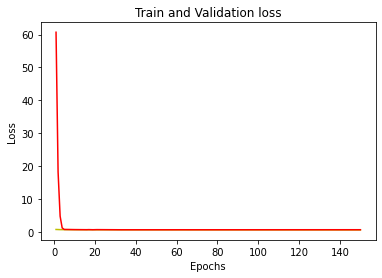

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Train and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##**metric - iou_score**

In [ ]:
pred_val = model2.predict(np.array(Val['img']), verbose=1)

60/60 [==============================] - 12s 200ms/sample


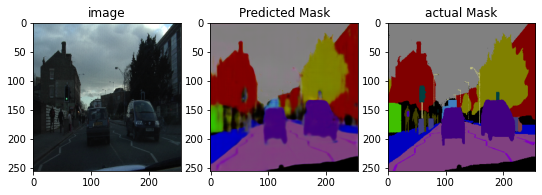

In [ ]:
Plotter(Val['img'][4], pred_val[4], Val['mask'][4])

In [ ]:
_, acc = model2.evaluate(np.array(Val['img']), np.array(Val['mask']), verbose=1)
print("Accuracy is = ", (acc * 100.0), "%")

60/60 [==============================] - 13s 209ms/sample - loss: 0.5788 - iou_score: 0.2800
Accuracy is =  28.004521131515503 %


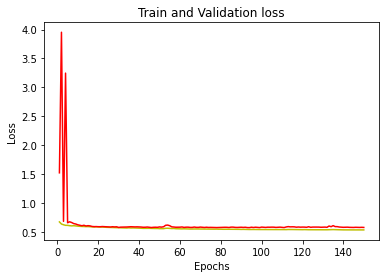

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Train and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##**metric - dice coeeficient**

In [ ]:
pred_val = model3.predict(np.array(Val['img']), verbose=1)

2/2 [==============================] - 12s 5s/step


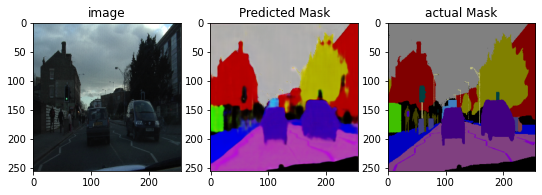

In [ ]:
Plotter(Val['img'][4], pred_val[4], Val['mask'][4])

In [ ]:
_, acc = model3.evaluate(np.array(Val['img']), np.array(Val['mask']), verbose=1)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 14s 7s/step - loss: 1.3171 - dice_coefficient: 0.5152
Accuracy is =  51.51814818382263 %


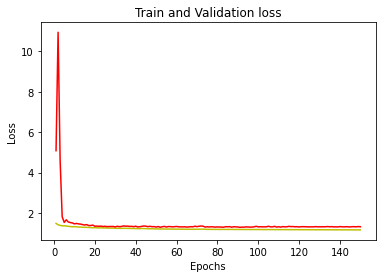

In [ ]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Train and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()